In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

from tqdm import tqdm
from matplotlib import pyplot as plt

from utils.adversarial_tests import compare_test
from networks.rnn import CNNLSTM

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

/Users/bliu/Documents/adversarial-networks/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device: cpu


In [4]:
transform = transforms.Compose([transforms.ToTensor()])

# Download CIFAR10 dataset

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Create data loaders
train_loader= torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


In [5]:
# Create the model
model = CNNLSTM().to(device)
# Define the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

EPOCHS = 10

In [1]:
# # train the batch_size=1 model
# # Train the model
# progress = tqdm(total=len(train_loader)*EPOCHS, desc="Training") # add a progress bar
# for epoch in range(EPOCHS):
#     for images, labels in train_loader:
#         model.train()
#         images = images.to(device)
#         labels = labels.to(device)

#         # Forward pass
#         outputs = model(images)
#         loss = criterion(outputs, labels)
        
#         # Backward and optimize
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         progress.update(1)
    
#     progress.write(f'Epoch [{epoch+1}/{10}], Loss: {loss.item():.4f}')

# # saving model
# torch.save(model.state_dict(), "models/cnn-lstm-batchsize1.pth")

In [23]:
BASE_MODEL_PATH = "./models/cnn-lstm.pth" 
base_model = CNNLSTM().to(device)
base_model.load_state_dict(torch.load(BASE_MODEL_PATH))
EPOCHS = 10
# EPSILONS =  [0.005, 0.01, 0.015, 0.2]
EPSILONS =  [0.01, 0.015, 0.2]

In [7]:
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=True)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
accuracies = {}
losses = {}

In [11]:
class FGSMTransform:
    """Perform a fast gradient sign attack on an image."""

    def __init__(self, epsilon=0.005, prob=1):
        self.epsilon = epsilon
        self.model = CNNLSTM().to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
        self.model.load_state_dict(torch.load("./models/cnn-lstm.pth"))
        self.criterion = torch.nn.CrossEntropyLoss()
        self.prob = prob #probability of applying fgsm on an image
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
    def __call__(self,sample):
        x, labels = sample
        if np.random.rand() >= self.prob:
            return x
        #if we process a single image instead of batch, we need to add a fourth dimension as the batch dimension
        x = x.unsqueeze(0)
        x = x.to(self.device)
        x.requires_grad = True

        # forward, backward pass to calculate gradient
        output = self.model(x)
        loss = self.criterion(output, labels.unsqueeze(0))
        self.model.zero_grad()
        loss.backward()

        # Collect gradients
        data_grad = x.grad.data

        # Call FGSM Attack, same as fgsm()
        sign_data_grad = data_grad.sign()
        perturbed_images = x + self.epsilon * sign_data_grad
        perturbed_images = torch.clamp(perturbed_images, 0, 1)
        return perturbed_images.squeeze(0)
    
class ToTensor:
    """Convert ndarrays in sample to Tensors. Works the same as transforms.ToTensor() but includes labels"""
    def __call__(self, sample):
        x, label = sample
        return (transforms.functional.to_tensor(x), torch.from_numpy(np.array(label)))

In [28]:
def compare_test(base_path, eps=EPSILONS):
    """given ~two~ ONE model (changed from before), compare how they do under different epsilons of fgsm attack"""
    #testing our trained model
    base_model = CNNLSTM().to(device)
    base_model.load_state_dict(torch.load(base_path))
    base_model.eval()

    criterion = torch.nn.CrossEntropyLoss()

    accuracies = []
    losses = []
    for e in eps:
        transform_fgsm = transforms.Compose([
                ToTensor(),
                FGSMTransform(epsilon=e) #epsilon
            ])
        fgsm_test = CustomCIFAR(root='./data', train=False, transform=transform_fgsm)
        fgsm_loader = torch.utils.data.DataLoader(dataset=fgsm_test, batch_size=64)
        l, a = simple_test(test_loader=fgsm_loader, criterion=criterion, model=base_model)
        accuracies.append(a)
        losses.append(l)
    print("\tAccuracies:", accuracies)
    print("\tLosses:", losses)
    return accuracies, losses
    # print("Augmented model accuracies:", accuracies_fgsm)

In [24]:
for epsilon in EPSILONS:
    transform = transforms.Compose([transforms.ToTensor()])
    fgsm_transform = transforms.Compose([ToTensor(),FGSMTransform(epsilon=epsilon)])

    # Download CIFAR10 dataset
    train_dataset1 = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    train_dataset2 = CustomCIFAR(root='./data', train=True, transform=fgsm_transform)
    augmented_dataset = torch.utils.data.ConcatDataset([train_dataset1, train_dataset2])
    # Create data loaders
    train_loader= torch.utils.data.DataLoader(dataset=augmented_dataset, batch_size=64, shuffle=True)

    # Train the model
    model = CNNLSTM().to(device)
    # Define the loss function and optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    print("Training model with epsilon: ", epsilon)
    for epoch in range(EPOCHS):
        for images, labels in train_loader:
            model.train()
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # #saving model
    name =  str(epsilon)[2:]
    torch.save(model.state_dict(), "./models/cnn-lstm_fgsm"+name+".pth")
    #testing model
    accuracies[epsilon], losses[epsilon] = compare_test("./models/cnn-lstm_fgsm"+name+".pth")

Files already downloaded and verified
Training model with epsilon:  0.01
Loss: 1.2616, Accuracy: 0.7187
Loss: 1.3051, Accuracy: 0.7104
Loss: 5.1567, Accuracy: 0.1866
	Accuracies: [0.71865046, 0.71039015, 0.1866043]
	Losses: [1.2615609, 1.3050773, 5.156654]
Files already downloaded and verified
Training model with epsilon:  0.015
Loss: 1.2186, Accuracy: 0.7323
Loss: 1.2448, Accuracy: 0.7282
Loss: 4.7040, Accuracy: 0.2138
	Accuracies: [0.732285, 0.7282046, 0.21377389]
	Losses: [1.2185735, 1.2448173, 4.70396]
Files already downloaded and verified
Training model with epsilon:  0.2
Loss: 1.0548, Accuracy: 0.7043
Loss: 1.0413, Accuracy: 0.7069
Loss: 0.9051, Accuracy: 0.7503
	Accuracies: [0.70431924, 0.70690686, 0.75029856]
	Losses: [1.0547514, 1.0413243, 0.9050537]


In [17]:
accuracies[0], losses[0] = compare_test("./models/cnn-lstm.pth")
accuracies[0.005], losses[0.005] = compare_test("./models/cnn-lstm_fgsm005.pth")

Loss: 1.6762, Accuracy: 0.5311
Loss: 2.1762, Accuracy: 0.4284
Loss: 4.3125, Accuracy: 0.0886
	Accuracies: [0.531051, 0.42844346, 0.08857484]
	Losses: [1.6761724, 2.1761963, 4.312521]
Loss: 1.2430, Accuracy: 0.7267
Loss: 1.3245, Accuracy: 0.7108
Loss: 6.6111, Accuracy: 0.1366
	Accuracies: [0.7267118, 0.7107882, 0.13664411]
	Losses: [1.2429622, 1.3245274, 6.6111073]


Loss: 0.6435, Accuracy: 0.7900
Loss: 2.5815, Accuracy: 0.3546
Loss: 3.4595, Accuracy: 0.2137
Loss: 3.7455, Accuracy: 0.1671
Loss: 3.8329, Accuracy: 0.1409
Loss: 3.8892, Accuracy: 0.1268
	Accuracies: [0.79000795, 0.35459793, 0.21367437, 0.16709793, 0.14092356, 0.1267914]
	Losses: [0.64346004, 2.581487, 3.4594796, 3.7455175, 3.832866, 3.8892255]
Loss: 1.1108, Accuracy: 0.7512
Loss: 1.4274, Accuracy: 0.6902
Loss: 2.0919, Accuracy: 0.5806
Loss: 2.8747, Accuracy: 0.4607
Loss: 3.5810, Accuracy: 0.3669
Loss: 4.1977, Accuracy: 0.3011
	Accuracies: [0.75119424, 0.6901871, 0.5806131, 0.46068868, 0.36693868, 0.30105492]
	Losses: [1.1107652, 1.4273956, 2.0919132, 2.874687, 3.5809882, 4.197693]
Loss: 1.1850, Accuracy: 0.7331
Loss: 1.3593, Accuracy: 0.7011
Loss: 1.7815, Accuracy: 0.6286
Loss: 2.4671, Accuracy: 0.5230
Loss: 3.1347, Accuracy: 0.4273
Loss: 3.6624, Accuracy: 0.3560
	Accuracies: [0.7330812, 0.70113456, 0.6285828, 0.52298963, 0.42734873, 0.35599124]
	Losses: [1.1849941, 1.3593006, 1.781523

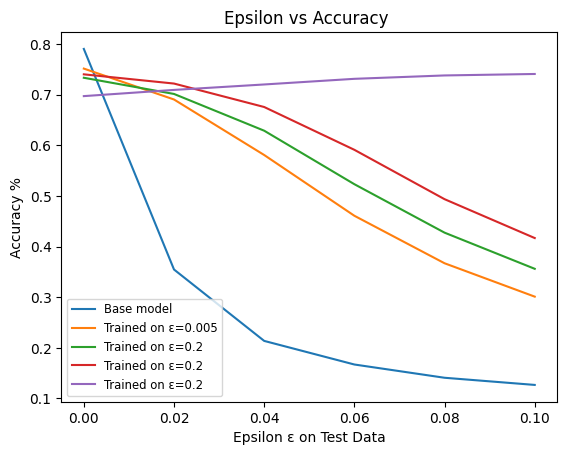

In [30]:
additional_epsilons = [0, 0.02,0.04,0.06,0.08,0.1]
plt.title("Epsilon vs Accuracy ")
a, l = compare_test("./models/cnn-lstm.pth",additional_epsilons)
plt.plot(additional_epsilons,a, "-",label="Base model")
a, l = compare_test("./models/cnn-lstm_fgsm005.pth",additional_epsilons)
plt.plot(additional_epsilons, a, "-",label="Trained on \u03B5="+str(0.005))
for e in EPSILONS:
    a, l = compare_test("./models/cnn-lstm_fgsm"+str(e)[2:]+".pth", additional_epsilons)
    plt.plot(additional_epsilons, a, "-",label="Trained on \u03B5="+str(e))
plt.xlabel("Epsilon \u03B5 on Test Data")
plt.ylabel("Accuracy %")
plt.legend(loc="lower left", fontsize='small')
plt.show()

```Loss: 0.6435, Accuracy: 0.7900
Loss: 2.5815, Accuracy: 0.3546
Loss: 3.4595, Accuracy: 0.2137
Loss: 3.7455, Accuracy: 0.1671
Loss: 3.8329, Accuracy: 0.1409
Loss: 3.8892, Accuracy: 0.1268
	Accuracies: [0.79000795, 0.35459793, 0.21367437, 0.16709793, 0.14092356, 0.1267914]
	Losses: [0.64346004, 2.581487, 3.4594796, 3.7455175, 3.832866, 3.8892255]
Loss: 1.1108, Accuracy: 0.7512
Loss: 1.4274, Accuracy: 0.6902
Loss: 2.0919, Accuracy: 0.5806
Loss: 2.8747, Accuracy: 0.4607
Loss: 3.5810, Accuracy: 0.3669
Loss: 4.1977, Accuracy: 0.3011
	Accuracies: [0.75119424, 0.6901871, 0.5806131, 0.46068868, 0.36693868, 0.30105492]
	Losses: [1.1107652, 1.4273956, 2.0919132, 2.874687, 3.5809882, 4.197693]
Loss: 1.1850, Accuracy: 0.7331
Loss: 1.3593, Accuracy: 0.7011
Loss: 1.7815, Accuracy: 0.6286
Loss: 2.4671, Accuracy: 0.5230
Loss: 3.1347, Accuracy: 0.4273
Loss: 3.6624, Accuracy: 0.3560
	Accuracies: [0.7330812, 0.70113456, 0.6285828, 0.52298963, 0.42734873, 0.35599124]
	Losses: [1.1849941, 1.3593006, 1.7815233, 2.4671285, 3.1346896, 3.6624405]
Loss: 1.1736, Accuracy: 0.7398
Loss: 1.2774, Accuracy: 0.7216
Loss: 1.5453, Accuracy: 0.6754
Loss: 2.0448, Accuracy: 0.5909
Loss: 2.5919, Accuracy: 0.4934
Loss: 3.0778, Accuracy: 0.4167
	Accuracies: [0.73984873, 0.7216362, 0.6753583, 0.5908638, 0.49343154, 0.41669983]
	Losses: [1.173556, 1.2774067, 1.545272, 2.0448382, 2.591919, 3.0778081]
Loss: 1.0846, Accuracy: 0.6969
Loss: 1.0290, Accuracy: 0.7091
Loss: 0.9868, Accuracy: 0.7198
Loss: 0.9541, Accuracy: 0.7310
Loss: 0.9278, Accuracy: 0.7377
Loss: 0.9054, Accuracy: 0.7405
	Accuracies: [0.69685507, 0.7090963, 0.71984476, 0.73099124, 0.7376592, 0.7405454]
	Losses: [1.0845886, 1.0289847, 0.98680824, 0.9541277, 0.9277905, 0.9053531]```

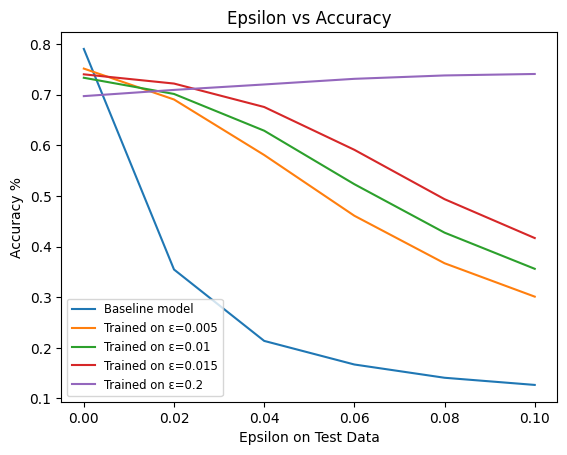

In [7]:
additional_epsilons = [0, 0.02,0.04,0.06,0.08,0.1]
plt.title("Epsilon vs Accuracy")
a_baseline = [0.79000795, 0.35459793, 0.21367437, 0.16709793, 0.14092356, 0.1267914]
plt.plot(additional_epsilons, a_baseline, "-",label="Baseline model")
a_005 = [0.75119424, 0.6901871, 0.5806131, 0.46068868, 0.36693868, 0.30105492]
plt.plot(additional_epsilons, a_005, "-",label="Trained on \u03B5="+str(0.005))
a_001 = [0.7330812, 0.70113456, 0.6285828, 0.52298963, 0.42734873, 0.35599124]
plt.plot(additional_epsilons, a_001, "-",label="Trained on \u03B5="+str(0.01))
a_0015 = [0.73984873, 0.7216362, 0.6753583, 0.5908638, 0.49343154, 0.41669983]
plt.plot(additional_epsilons, a_0015, "-",label="Trained on \u03B5="+str(0.015))
a_02 = [0.69685507, 0.7090963, 0.71984476, 0.73099124, 0.7376592, 0.7405454]
plt.plot(additional_epsilons, a_02, "-",label="Trained on \u03B5="+str(0.2))
plt.xlabel("Epsilon on Test Data")
plt.ylabel("Accuracy %")
plt.legend(loc="lower left", fontsize='small')
plt.show()

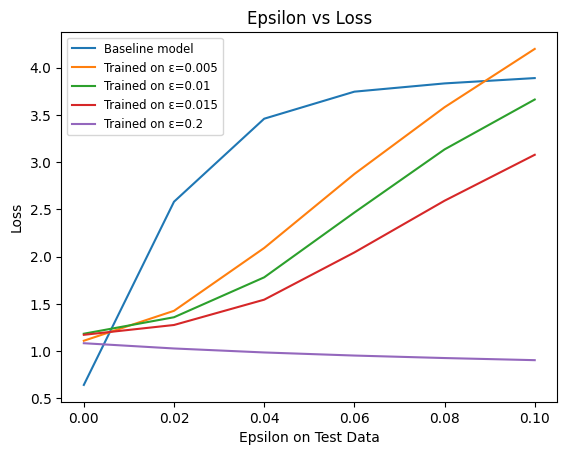

In [10]:
import matplotlib.pyplot as plt

additional_epsilons = [0, 0.02,0.04,0.06,0.08,0.1]
plt.title("Epsilon vs Loss")
l_baseline = [0.64346004, 2.581487, 3.4594796, 3.7455175, 3.832866, 3.8892255]
plt.plot(additional_epsilons, l_baseline, "-",label="Baseline model")
l_005 = [1.1107652, 1.4273956, 2.0919132, 2.874687, 3.5809882, 4.197693]
plt.plot(additional_epsilons, l_005, "-",label="Trained on \u03B5="+str(0.005))
l_001 = [1.1849941, 1.3593006, 1.7815233, 2.4671285, 3.1346896, 3.6624405]
plt.plot(additional_epsilons, l_001, "-",label="Trained on \u03B5="+str(0.01))
l_0015 = [1.173556, 1.2774067, 1.545272, 2.0448382, 2.591919, 3.0778081]
plt.plot(additional_epsilons, l_0015, "-",label="Trained on \u03B5="+str(0.015))
l_02 = [1.0845886, 1.0289847, 0.98680824, 0.9541277, 0.9277905, 0.9053531]
plt.plot(additional_epsilons, l_02, "-",label="Trained on \u03B5="+str(0.2))
plt.xlabel("Epsilon on Test Data")
plt.ylabel("Loss")
plt.legend(loc="upper left", fontsize='small')
plt.show()